In [1]:
import os 
import cv2
import glob
import numpy as np

ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'drive/MyDrive/img/GTSRB/Final_Training/Images')

image_list = []
label_list = []
image_label_list = os.listdir(DATA_ROOT_DIR)

for label_name in image_label_list:
  # 이미지 파일 읽어오기
  file_path = os.path.join(DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.ppm')

  # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .ppm 파일 읽어서 리스트에 저장

  for img_file in img_file_list:
    try:
      src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
      src_img = cv2.resize(src_img, dsize=(32, 32))
      src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

      image_list.append(src_img)
      label_list.append(float(label_name))

    except Exception as err:
      print(str(err), img_file)
      continue

In [4]:
x_train = np.array(image_list).astype('float32')
y_train = np.array(label_list).astype('float32')

s = np.arange(len(x_train)) # index list

np.random.shuffle(s) # index random shuffle

x_train = x_train[s]
y_train = y_train[s]

SPLIT_RATIO = 0.2 # 20%
SPLIT_NUMS = int(SPLIT_RATIO * len(x_train))

x_test = x_train[0:SPLIT_NUMS]
y_test = y_train[0:SPLIT_NUMS]

x_train = x_train[SPLIT_NUMS:]
y_train = y_train[SPLIT_NUMS:]

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print('x_train.shape: ', x_train.shape, 'y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape, 'y_test.shape: ', y_test.shape)

x_train.shape:  (31380, 32, 32, 3) y_train.shape:  (31380,)
x_test.shape:  (7844, 32, 32, 3) y_test.shape:  (7844,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

n_classes = len(os.listdir(DATA_ROOT_DIR)) # 정답 개수

model = Sequential()

model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3), filters=32, activation='relu'))
model.add(Conv2D(kernel_size=(3, 3), filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 256)               3211520   
                                                        

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[earlystopping])

Epoch 1/30
981/981 [==============================] - 18s 7ms/step - loss: 0.9532 - accuracy: 0.7353 - val_loss: 0.1728 - val_accuracy: 0.9657
Epoch 2/30
981/981 [==============================] - 6s 6ms/step - loss: 0.2182 - accuracy: 0.9355 - val_loss: 0.0724 - val_accuracy: 0.9810
Epoch 3/30
981/981 [==============================] - 7s 7ms/step - loss: 0.1317 - accuracy: 0.9624 - val_loss: 0.0424 - val_accuracy: 0.9898
Epoch 4/30
981/981 [==============================] - 6s 6ms/step - loss: 0.0960 - accuracy: 0.9704 - val_loss: 0.0380 - val_accuracy: 0.9918
Epoch 5/30
981/981 [==============================] - 6s 6ms/step - loss: 0.0729 - accuracy: 0.9775 - val_loss: 0.0350 - val_accuracy: 0.9926
Epoch 6/30
981/981 [==============================] - 6s 6ms/step - loss: 0.0629 - accuracy: 0.9808 - val_loss: 0.0329 - val_accuracy: 0.9932
Epoch 7/30
981/981 [==============================] - 6s 6ms/step - loss: 0.0559 - accuracy: 0.9820 - val_loss: 0.0269 - val_accuracy: 0.9953
Epoch

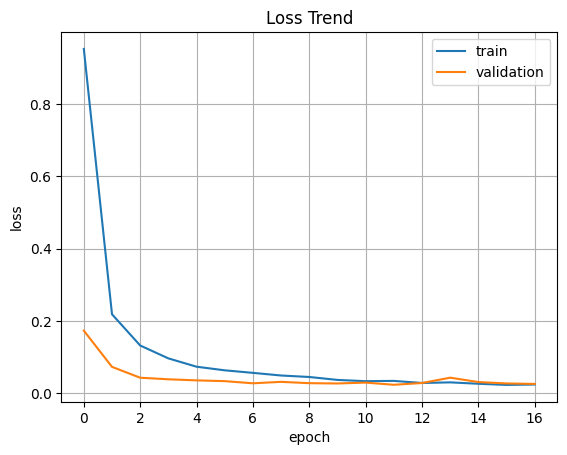

In [9]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()

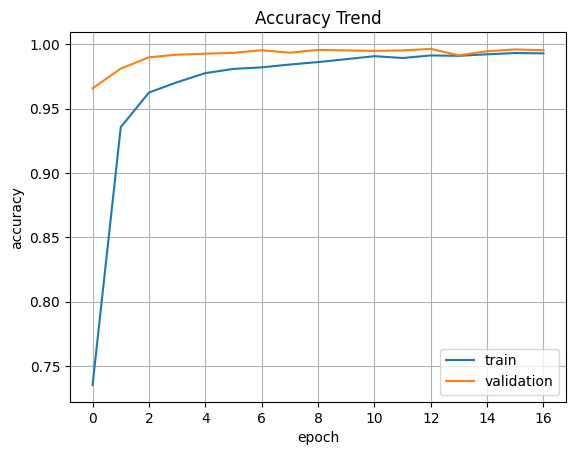

In [10]:
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()